In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import json
import re
import pickle
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ,CSVLogger
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
from math import ceil
%matplotlib inline

In [ ]:
import os
import re

def extract_index_from_filename(filename):
    # Use regular expression to extract the index inside parentheses
    match = re.search(r'\((\d+)\)', filename)
    if match:
        return int(match.group(1))
    else:
        return None

def load_data_with_mapping(image_size=(224, 224, 3), to_array=True):
    all_image = []
    all_mask = []
    image_path = '/content/drive/MyDrive/1 WCEBleedGen Challenge/Training set/bleeding/Images'
    mask_path = '/content/drive/MyDrive/1 WCEBleedGen Challenge/Training set/bleeding/Annotations'

    # Create mappings between image and mask filenames
    image_mapping = {}
    mask_mapping = {}

    for image_name in os.listdir(image_path):
        image_index = extract_index_from_filename(image_name)
        if image_index is not None:
            image_mapping[image_index] = os.path.join(image_path, image_name)

    for mask_name in os.listdir(mask_path):
        mask_index = extract_index_from_filename(mask_name)
        if mask_index is not None:
            mask_mapping[mask_index] = os.path.join(mask_path, mask_name)

    # Iterate through the indices and create pairs of image and mask
    common_indices = set(image_mapping.keys()) & set(mask_mapping.keys())

    for index in common_indices:
        image_filename = image_mapping[index]
        mask_filename = mask_mapping[index]

        image = cv2.imread(image_filename, 1)
        image = cv2.resize(image, (image_size[0], image_size[1]))  # Resize width and height
        image = image / 255.0
        image = image.astype(np.float32)
        all_image.append(image)

        mask = cv2.imread(mask_filename, 0)
        mask = cv2.resize(mask, (image_size[0], image_size[1]))
        mask = mask / 255.0
        mask = mask.astype(np.float32)
        all_mask.append(mask)

    if to_array:
        all_image = np.array(all_image)
        all_mask = np.array(all_mask)

    return all_image, all_mask

x_1, y_1 = load_data_with_mapping(image_size=(224, 224, 3), to_array=False)


In [ ]:
print(type(x_1),type(y_1))
print(len(x_1),len(y_1))

<class 'list'> <class 'list'>
1309 1309


In [ ]:
x_final=np.array(x_1)
y_final=np.array(y_1)

In [ ]:
y_final.shape

(1309, 224, 224)

In [ ]:
def split_data(test_size=0.2,log=True,shuffle=True):
    x_train, x_test_val, y_train, y_test_val = train_test_split(x_final, y_final, test_size=test_size,shuffle=shuffle)
    if log==True :
        print('Input: ')
        print(x_final.shape,(y_final).shape)
        print('----------------------------')

    x_test=x_test_val[:int(len(x_test_val)*0.5)]
    x_val=x_test_val[int(len(x_test_val)*0.5):]
    y_test=y_test_val[:int(len(y_test_val)*0.5)]
    y_val=y_test_val[int(len(y_test_val)*0.5):]


    x_train=x_train.reshape(-1,224,224,3)
    y_train=y_train.reshape(-1,224,224,1)
    x_test=x_test.reshape(-1,224,224,3)
    y_test=y_test.reshape(-1,224,224,1)
    x_val=x_val.reshape(-1,224,224,3)
    y_val=y_val.reshape(-1,224,224,1)
    if log==True :
        print('Output: ')
        print(x_train.shape,y_train.shape)
        print(x_test.shape,(y_test).shape)
        print(x_val.shape,y_val.shape)
        print('----------------------------')
    return x_train,y_train,x_test,y_test,x_val,y_val
x_train,y_train,x_test,y_test,x_val,y_val=split_data()
validation_dataset=(x_val,y_val)

Input: 
(1309, 224, 224, 3) (1309, 224, 224)
----------------------------
Output: 
(1047, 224, 224, 3) (1047, 224, 224, 1)
(131, 224, 224, 3) (131, 224, 224, 1)
(131, 224, 224, 3) (131, 224, 224, 1)
----------------------------


# Build U-Net Model
sementic segmentation Model



In [ ]:
def double_conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def Build_Unet_Model(num_filters=64,input_shape=(224,224,3)):
    inputs = Input(input_shape)
    f_1 = double_conv_block(inputs, num_filters*1)
    p_1 = MaxPool2D((2, 2))(f_1)
    f_2 = double_conv_block(p_1, num_filters*2)
    p_2 = MaxPool2D((2, 2))(f_2)
    f_3 = double_conv_block(p_2, num_filters*4)
    p_3 = MaxPool2D((2, 2))(f_3)
    f_4 = double_conv_block(p_3, num_filters*8)
    p_4 = MaxPool2D((2, 2))(f_4)

    c=double_conv_block(p_4,num_filters*16)

    d_1 = Conv2DTranspose(num_filters*8, 2, strides=2, padding="same")(c)
    d_1= Concatenate()([d_1, f_4])
    d_1 = double_conv_block(d_1, num_filters*8)

    d_2 = Conv2DTranspose(num_filters*4, 2, strides=2, padding="same")(d_1)
    d_2= Concatenate()([d_2, f_3])
    d_2 = double_conv_block(d_2, num_filters*4)

    d_3 = Conv2DTranspose(num_filters*2, 2, strides=2, padding="same")(d_2)
    d_3= Concatenate()([d_3, f_2])
    d_3 = double_conv_block(d_3, num_filters*2)

    d_4 = Conv2DTranspose(num_filters*1, 2, strides=2, padding="same")(d_3)
    d_4= Concatenate()([d_4, f_1])
    d_4 = double_conv_block(d_4, num_filters*1)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d_4)
    Unet_Model = Model(inputs, outputs, name="UNetModel")
    return Unet_Model

In [ ]:
Unet_Model = Build_Unet_Model()
Unet_Model.summary()

Model: "UNetModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[

In [19]:
def Dice_Coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth), axis=0)
    return dice

def Dice_Loss(y_true, y_pred):
    return 1.0 - Dice_Coefficient(y_true, y_pred)

In [ ]:
Unet_Model.compile(loss=Dice_Loss , optimizer='adam', metrics=[Dice_Coefficient,"binary_accuracy"])

In [ ]:
def make_callbacks(csv_path='my_new_log_3_seg.csv'):
    early_stop=EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=False)
    csv_logger=CSVLogger(csv_path)
    callbacks =[early_stop,csv_logger]
    return callbacks
callbacks=make_callbacks()

# time to train the Model

In [ ]:
epochs = 90
Unet_Model.fit(x_train, y_train, epochs=epochs,batch_size=16,verbose=1,validation_data=validation_dataset,callbacks=callbacks)

Epoch 1/90
66/66 [==============================] - 96s 849ms/step - loss: 0.4815 - Dice_Coefficient: 0.5190 - binary_accuracy: 0.8091 - val_loss: 0.6705 - val_Dice_Coefficient: 0.3301 - val_binary_accuracy: 0.4239
Epoch 2/90
66/66 [==============================] - 43s 659ms/step - loss: 0.4426 - Dice_Coefficient: 0.5557 - binary_accuracy: 0.8356 - val_loss: 0.9683 - val_Dice_Coefficient: 0.0310 - val_binary_accuracy: 0.7696
Epoch 3/90
66/66 [==============================] - 43s 654ms/step - loss: 0.4301 - Dice_Coefficient: 0.5718 - binary_accuracy: 0.8425 - val_loss: 0.9869 - val_Dice_Coefficient: 0.0126 - val_binary_accuracy: 0.8095
Epoch 4/90
66/66 [==============================] - 44s 662ms/step - loss: 0.4195 - Dice_Coefficient: 0.5809 - binary_accuracy: 0.8446 - val_loss: 0.9927 - val_Dice_Coefficient: 0.0069 - val_binary_accuracy: 0.8094
Epoch 5/90
66/66 [==============================] - 45s 682ms/step - loss: 0.4072 - Dice_Coefficient: 0.5929 - binary_accuracy: 0.8491 - val

In [ ]:
Unet_Model.save('Bleeding & Non-Bleeding segmetation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Unet_Model = load_model('Bleeding & Non-Bleeding segmetation.h5', custom_objects={'Dice_Loss':
Dice_Loss,'Dice_Coefficient':Dice_Coefficient})

In [ ]:
print(type(Unet_Model))

<class 'keras.src.engine.functional.Functional'>


In [ ]:
Model_loss, Model_accuracy,*anything = Unet_Model.evaluate(x_test,y_test)

print(f"it is Model accuracy: {Model_accuracy}")
print(f'it is Model loss: {Model_loss}')

5/5 [==============================] - 16s 322ms/step - loss: 0.3399 - Dice_Coefficient: 0.6509 - binary_accuracy: 0.8758
it is Model accuracy: 0.6508812308311462
it is Model loss: 0.3399292230606079


1/1 [==============================] - 1s 1s/step


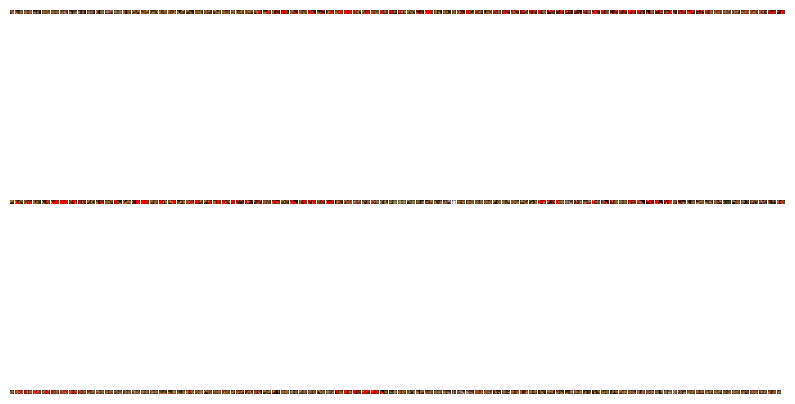

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from keras.models import load_model

def combine_pred_original(path, output_dir=None, dir_path=False, plot=False):
    Unet_Model = load_model('/content/drive/MyDrive/WCE Unet Model/Models/Bleeding & Non-Bleeding segmetation.h5', custom_objects={'Dice_Loss': Dice_Loss, 'Dice_Coefficient': Dice_Coefficient})

    def create_mask(image):
        # Normalize pixel values to the range [0, 1]
        image = image / 255.0
        image = image.astype(np.float32)

        # Expand dimensions to match the model's input shape
        image = image.reshape(1, 224, 224, 3)

        # Predict the mask
        y_hat = Unet_Model.predict(image)

        # Reshape the mask to 224x224 binary mask
        mask = (y_hat > 0.5).astype(np.uint8)  # Adjust the threshold as needed
        return mask[0, :, :, 0]  # Get the first (and only) mask from the batch

    if not dir_path:
        # Load and preprocess the image
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224))

        mask = create_mask(image)

        # Set pixels in the mask to red in the original image
        masked_image = image.copy()
        masked_image[mask == 1] = [0, 0, 255]  # Set bleeding regions to red (BGR format)

        if plot:
            plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')

        if output_dir:
            output_path = os.path.join(output_dir, os.path.basename(path))
            cv2.imwrite(output_path, masked_image)

        return cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    else:
        all_results = {}
        all_img_names = os.listdir(path)

        if plot:
            rows, columns = 3, ceil(len(all_img_names) / 3)
            fig = plt.figure(figsize=(10, 7))

        for c, name in enumerate(all_img_names):
            # Load and preprocess the image
            image = cv2.imread(os.path.join(path, name))
            image = cv2.resize(image, (224, 224))

            mask = create_mask(image)

            # Set pixels in the mask to red in the original image
            masked_image = image.copy()
            masked_image[mask == 1] = [0, 0, 255]  # Set bleeding regions to red (BGR format)

            all_results[name] = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

            if plot:
                fig.add_subplot(rows, columns, c + 1)
                plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
                plt.axis('off')

            if output_dir:
                output_path = os.path.join(output_dir, name)
                cv2.imwrite(output_path, masked_image)

        return all_results

# Example usage:
# Provide the output directory path to save predicted images
output_directory = '/content/drive/MyDrive/WCE Unet Model/Segmentated Images'
a = combine_pred_original(path='/content/drive/MyDrive/1 WCEBleedGen Challenge/Testing set/Test Dataset 2', output_dir=output_directory, dir_path=True, plot=True)


In [ ]:
csv=pd.read_csv('/content/my_new_log_3_seg.csv')

accuracy=csv['Dice_Coefficient']
val_accuracy=csv['val_Dice_Coefficient']
loss=csv['loss']
val_loss=csv['val_loss']

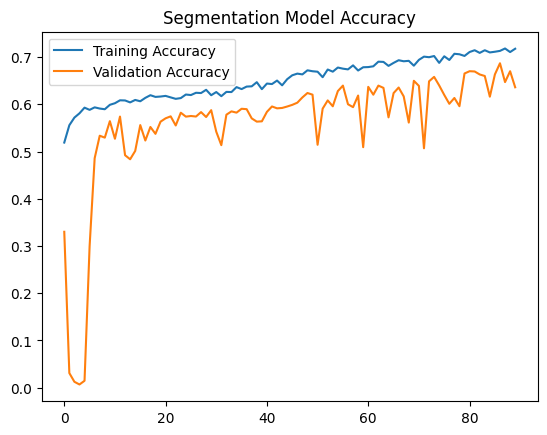

In [ ]:
plt.plot(accuracy,label='Training Accuracy')
plt.plot(val_accuracy,label='Validation Accuracy')
plt.legend()
plt.title('Segmentation Model Accuracy')
plt.show()


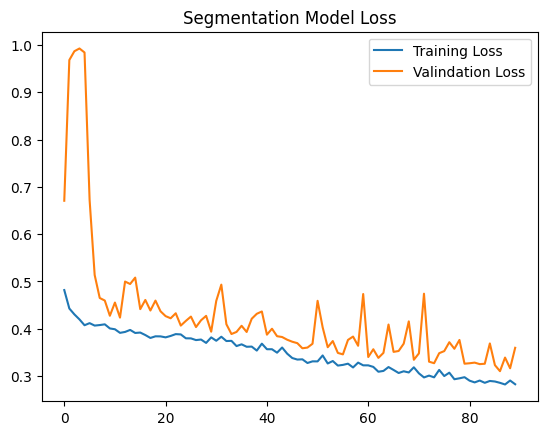

In [ ]:
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Valindation Loss')
plt.legend()
plt.title('Segmentation Model Loss')
plt.show()